In [1]:
#import torch
import os, sys, re, time
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
#import torch
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")

113706


In [2]:
import cv2
from ChromAn.src.file_io.data_organization import search_fovs_in_folders, Color_Usage
from ChromAn.src.segmentation_tools.cells import Align_Segmentation

In [3]:
import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation
from copy import copy

In [4]:
# Cellpose 
from cellpose import models

## Folders

In [5]:
# data_folder
data_folder = r'/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5'
# correction
correction_folder = r'/lab/weissman_imaging/puzheng/Corrections/20240401-Merscope01_s11_n1200'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    print(segmentation_save_folder)
    os.makedirs(segmentation_save_folder)
watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation
/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/watershed


In [6]:
# transpose with microscope
parameter_folder = r'/lab/weissman_imaging/puzheng/Softwares/Weissman_MERFISH_Scripts/merlin_parameters'
microscope_file = os.path.join(parameter_folder, 'microscope', 'merscope01_microscope.json')
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.107,
 'image_dimensions': [2304, 2304]}

In [7]:
# search folders
folders, fovs = search_fovs_in_folders(data_folder)
# Color usage file marks the organization of imaging files
color_usage_filename = os.path.join(data_folder, 'Analysis', 'color_usage_MF5.csv')
color_usage_df = Color_Usage(color_usage_filename)

- searching in folder: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5
-- 14 folders, 158 fovs detected.
- load color_usage from file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Analysis/color_usage_MF5.csv


In [8]:
# from color_usage, find dapi / polyt / fiducial
dapi_info = color_usage_df.get_dapi_info()[0]
polyt_info = color_usage_df.get_polyt_info()[0]
fiducial_channel = color_usage_df.get_fiducial_channel(color_usage_df)
print(dapi_info, polyt_info, fiducial_channel)

{'hyb': 'H0M1', 'channel': '405'} {'channel': '637', 'hyb': 'H12M13'} 477


# Run segmentation

In [9]:
from ChromAn.src.file_io.dax_process import DaxProcesser
from ChromAn.src.visual_tools.interactive import imshow_mark_3d
from merlin.analysis.segment import CellPoseSegment

In [10]:
from importlib import reload

In [11]:
import ChromAn
reload(ChromAn.src.file_io.dax_process)

<module 'ChromAn.src.file_io.dax_process' from '/lab/weissman_imaging/puzheng/Softwares/ChromAn/src/file_io/dax_process.py'>

In [12]:

for _fov_id, _fov_name in enumerate(fovs):


    _save_id = _fov_id 
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(seg_save_file):
        print(f"Segmentation label file: {seg_save_file} already exists, skip")
        continue
    
    ref_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel,dapi_info['channel']])
    #_ref_cls._corr_illumination()
    _ref_im = getattr(_ref_cls, f'im_{fiducial_channel}')
    
    # load polyT and DAPI
    _cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _cls.ref_correction_channel = '637'
    #_cls._corr_illumination()
    _cls._calculate_drift(_ref_im, )
    _cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    
    _dapi_im = getattr(_ref_cls, f"im_{dapi_info['channel']}")
    _polyt_im = getattr(_cls, f"im_{polyt_info['channel']}")
    # Run segmentation if target file not exist:
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- apply microscope corrections")
        dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
        polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

        # Create cellpose model
        print(f"- run Cellpose segmentation", end=' ')
        _cellpose_start = time.time()
        seg_model = models.CellposeModel(gpu=True, model_type='TN2')
        # Run cellpose prediction
        labels3d, _, _ = seg_model.eval(np.stack([polyt_im, dapi_im], axis=3), 
                                        #batch_size=60, #anisotropy=250/108,
                                        anisotropy=1200/108,
                                        cellprob_threshold=0, 
                                        channels=[1,2], 
                                        diameter=50, 
                                        min_size=2000,
                                        do_3D=False,
                                        )
        print(f"in {time.time()-_cellpose_start:.3f}s.")

        # convert to corrected labels
        corr_labels3d = CellPoseSegment.combine_2d_segmentation_masks_into_3d(labels3d)

        # save this segmentation mask
        print(f"- save to {np.max(corr_labels3d)} labels to file: {seg_save_file}")
        np.save(seg_save_file.split('.npy')[0], corr_labels3d, )
    
    

reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_000.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_000.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_000.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_000_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.273s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_000.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_000_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.225s.
+ Calculate drift with fiducial_channel: 477
-- start align

- Loaded images for channels:['477', '405'] in 2.496s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_005.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_005_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.094s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [  0.     3.37 -27.24] in 0.360s.
-- drift 1: [ 1.000e-02  3.640e+00 -2.776e+01] in 0.392s.
-- drift 2: [  0.     3.5  -27.53] in 0.358s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 6.055s.
- Finished warp correction in 6.055s.
- apply microscope corrections
- run Cellpose segmentation in 22.149s.
- save to 28 labe

- Loaded images for channels:['477', '405'] in 2.195s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_010.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_010_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.168s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-1.00e-02  4.24e+00 -2.83e+01] in 0.299s.
-- drift 1: [  0.     5.11 -26.26] in 0.372s.
-- drift 2: [-1.000e-02  5.130e+00 -2.794e+01] in 0.373s.
-- drift 3: [ 1.000e-02  5.090e+00 -2.706e+01] in 0.364s.
-- drift 4: [ 0.49 -0.04 -0.01] in 0.383s.
-- drift 5: [ 1.000e-02  5.520e+00 -2.567e+01] in 0.379s.
-- drift 6: [  0.     4.95 -28.05] in 0.368s.
-- drift 7: [-1.000e-02  5.470e+00 -2.612e+01] in 0.368s.
-- return a sub-optimal drift
- Start warpping images

- run Cellpose segmentation in 24.166s.
- save to 71 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_14.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_015.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_015.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_015.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_015_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.721s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_015.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_015_processed.hdf5
-- all used channels: [

-- corrected warp for channel 637 in 5.276s.
- Finished warp correction in 5.276s.
- apply microscope corrections
- run Cellpose segmentation in 26.130s.
- save to 144 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_19.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_020.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_020.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_020.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_020_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.913s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_020.dax
- New save file: /lab

-- corrected warp for channel 637 in 5.249s.
- Finished warp correction in 5.249s.
- apply microscope corrections
- run Cellpose segmentation in 26.024s.
- save to 90 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_24.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_025.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_025.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_025.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_025_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.000s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_025.dax
- New save file: /lab/

-- drift 3: [-1.000e-02  5.430e+00 -2.807e+01] in 0.291s.
-- drift 4: [ 1.000e-02  6.340e+00 -3.056e+01] in 0.320s.
-- drift 5: [  0.     5.38 -28.07] in 0.322s.
-- drift 6: [ 1.000e-02  5.430e+00 -2.815e+01] in 0.328s.
-- drift 7: [-2.000e-02  5.710e+00 -2.836e+01] in 0.316s.
-- return a sub-optimal drift
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 6.139s.
- Finished warp correction in 6.139s.
- apply microscope corrections
- run Cellpose segmentation in 21.867s.
- save to 31 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_29.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_030.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_030.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_03

- Loaded images for channels:['637', '477'] in 0.991s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 1.000e-02  5.250e+00 -2.901e+01] in 0.394s.
-- drift 1: [-1.000e-02  5.460e+00 -2.891e+01] in 0.419s.
-- drift 2: [-1.00e-02  5.44e+00 -2.90e+01] in 0.390s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 5.380s.
- Finished warp correction in 5.380s.
- apply microscope corrections
- run Cellpose segmentation in 27.066s.
- save to 78 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_34.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_035.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_035.dax
Initialize DaxProcesser 

-- drift 0: [  0.     4.48 -27.35] in 0.455s.
-- drift 1: [  0.     4.51 -27.92] in 0.349s.
-- drift 2: [-2.000e-02  4.690e+00 -2.732e+01] in 0.304s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 6.014s.
- Finished warp correction in 6.015s.
- apply microscope corrections
- run Cellpose segmentation in 24.089s.
- save to 45 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_39.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_040.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_040.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_040.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_

-- drift 1: [  0.     4.69 -28.9 ] in 0.487s.
-- drift 2: [-1.00e-02  4.90e+00 -2.87e+01] in 0.383s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 7.412s.
- Finished warp correction in 7.412s.
- apply microscope corrections
- run Cellpose segmentation in 27.495s.
- save to 109 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_44.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_045.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_045.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_045.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_045_processed.hdf5
-- all used channels: ['748',

- Loaded images for channels:['637', '477'] in 0.916s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 1.000e-02  2.450e+00 -2.951e+01] in 0.377s.
-- drift 1: [  0.     2.68 -29.85] in 0.407s.
-- drift 2: [  0.     2.28 -29.49] in 0.396s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 5.381s.
- Finished warp correction in 5.381s.
- apply microscope corrections
- run Cellpose segmentation in 24.812s.
- save to 89 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_49.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_050.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_050.dax
Initialize DaxProcesser for file:/lab/weissma

- Loaded images for channels:['637', '477'] in 0.991s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 1.000e-02  3.210e+00 -2.906e+01] in 0.295s.
-- drift 1: [  0.     3.3  -28.89] in 0.361s.
-- drift 2: [-1.000e-02  3.500e+00 -2.927e+01] in 0.413s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 5.421s.
- Finished warp correction in 5.422s.
- apply microscope corrections
- run Cellpose segmentation in 25.320s.
- save to 79 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_54.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_055.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_055.dax
Initialize DaxProcesser for file:

- Loaded images for channels:['477', '405'] in 0.225s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_115.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_115_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 0.177s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-2.000e-02  1.030e+00 -2.939e+01] in 0.411s.
-- drift 1: [  0.     1.47 -29.27] in 0.393s.
-- drift 2: [  0.     2.01 -29.42] in 0.386s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 5.299s.
- Finished warp correction in 5.299s.
- apply microscope corrections
- run Cellpose segmentation in 26.839s.
- save to 90 labe

-- drift 0: [ 1.000e-02  2.390e+00 -2.829e+01] in 0.291s.
-- drift 1: [  0.     2.45 -27.88] in 0.303s.
-- drift 2: [-1.000e-02  2.450e+00 -2.827e+01] in 0.376s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 6.764s.
- Finished warp correction in 6.764s.
- apply microscope corrections
- run Cellpose segmentation in 23.900s.
- save to 40 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_120.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_121.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_121.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_121.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M

-- drift 0: [ 1.000e-02  3.940e+00 -2.774e+01] in 0.586s.
-- drift 1: [  0.     4.19 -27.02] in 0.544s.
-- drift 2: [  0.16   3.47 -27.18] in 0.594s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 6.234s.
- Finished warp correction in 6.234s.
- apply microscope corrections
- run Cellpose segmentation in 24.816s.
- save to 68 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_125.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_126.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_126.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_126.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan

-- drift 0: [  -0.99   83.15 -105.17] in 0.455s.
-- drift 1: [  2.   176.18 188.42] in 0.477s.
-- drift 2: [  0.32   2.25 -26.92] in 0.475s.
-- drift 3: [ 1.000e-02  2.400e+00 -2.747e+01] in 0.471s.
-- drift 4: [ 1.000e-02  2.320e+00 -2.711e+01] in 0.467s.
-- drift 5: [  0.03   2.46 -27.34] in 0.468s.
-- drift 6: [ 1.000e-02  2.280e+00 -2.724e+01] in 0.470s.
-- drift 7: [ 2.000e-02  2.730e+00 -2.691e+01] in 0.470s.
-- return a sub-optimal drift
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 5.412s.
- Finished warp correction in 5.412s.
- apply microscope corrections
- run Cellpose segmentation in 26.381s.
- save to 125 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_130.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_131.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEco

- Loaded images for channels:['637', '477'] in 1.371s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 2.00e-02  2.97e+00 -2.69e+01] in 0.713s.
-- drift 1: [  0.    3.1 -26.8] in 0.582s.
-- drift 2: [ 2.000e-02  3.050e+00 -2.682e+01] in 0.539s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 6.007s.
- Finished warp correction in 6.007s.
- apply microscope corrections
- run Cellpose segmentation in 30.630s.
- save to 123 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_135.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_136.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_136.dax
Initialize DaxProcesser for file:/lab

- Loaded images for channels:['637', '477'] in 0.936s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [  0.     2.42 -27.66] in 0.432s.
-- drift 1: [ 1.000e-02  2.390e+00 -2.779e+01] in 0.424s.
-- drift 2: [ 1.000e-02  2.620e+00 -2.795e+01] in 0.540s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 6.625s.
- Finished warp correction in 6.625s.
- apply microscope corrections
- run Cellpose segmentation in 23.456s.
- save to 60 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_140.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_141.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_141.dax
Initialize DaxProcesser for file

- Loaded images for channels:['477', '405'] in 1.012s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_145.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_145_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.051s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [  0.    -0.33 -27.46] in 0.528s.
-- drift 1: [  0.    -0.22 -27.68] in 0.493s.
-- drift 2: [  0.    -0.15 -27.55] in 0.507s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 6.289s.
- Finished warp correction in 6.289s.
- apply microscope corrections
- run Cellpose segmentation in 22.741s.
- save to 20 labels to file: 

- Loaded images for channels:['477', '405'] in 0.950s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_150.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_150_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.042s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [  0.04   3.16 -27.48] in 0.307s.
-- drift 1: [ 1.000e-02  2.970e+00 -2.703e+01] in 0.433s.
-- drift 2: [ -1.   134.78  86.84] in 0.367s.
-- drift 3: [ 2.000e-02  3.120e+00 -2.732e+01] in 0.552s.
-- drift 4: [ 1.000e-02  3.220e+00 -2.764e+01] in 0.462s.
-- drift 5: [ 1.000e-02  3.060e+00 -2.717e+01] in 0.592s.
-- drift 6: [ 2.000e-02  2.990e+00 -2.734e+01] in 0.479s.
-- drift 7: [ 1.000e-02  2.690e+00 -2.729e+01] in 0.496s.
-- return a sub-optimal drift
- Sta

- Loaded images for channels:['477', '405'] in 1.829s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_155.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_155_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.077s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ -3.   131.34 -50.67] in 0.340s.
-- drift 1: [ 2.000e-02 -3.000e-02 -2.886e+01] in 0.325s.
-- drift 2: [  0.     0.11 -28.73] in 0.305s.
-- drift 3: [  0.    -0.04 -28.84] in 0.322s.
-- drift 4: [ 1.000e-02  7.000e-02 -2.828e+01] in 0.311s.
-- drift 5: [  0.     0.06 -28.77] in 0.318s.
-- drift 6: [ -4.   100.47  11.83] in 0.327s.
-- drift 7: [  0.     0.13 -28.89] in 0.339s.
-- return a sub-optimal drift
- Start warpping images drift:['637'], chromatic:[]
-

<IPython.core.display.Javascript object>


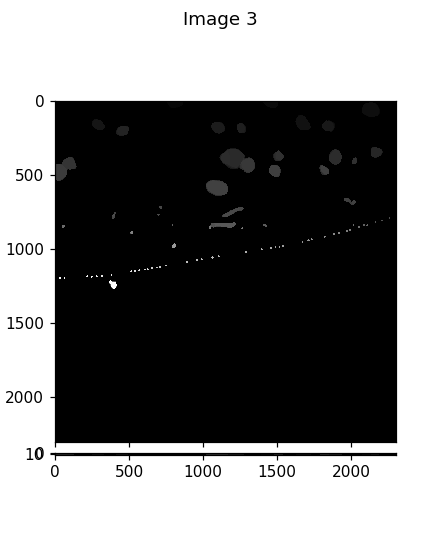

In [14]:
%matplotlib notebook
imshow_mark_3d([_dapi_im, _polyt_im, labels3d, corr_labels3d])

# STEP2: Watershed: Optional, potentially make it worse

In [13]:
watershed_th = 1.6

for _fov_id, _fov_name in enumerate(fovs):
    

    _save_id = _fov_id 
    
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        print(f"{watershed_save_file} already exists, skip")
        continue
    # Load segmentation
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- seg file: {seg_save_file} has not been generated yet, skip. ")
        continue
        
    ref_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel,dapi_info['channel']])
    _ref_cls._corr_illumination()
    _ref_im = getattr(_ref_cls, f'im_{fiducial_channel}')
    
    # load polyT and DAPI
    _cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    # extract images
    _dapi_im = copy(getattr(_ref_cls, f"im_{dapi_info['channel']}"))
    _polyt_im = copy(getattr(_cls, f"im_{polyt_info['channel']}"))
    
    
    _save_id = _fov_id 

    dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

    # Prepare watershed
    print(f"- run watershed", end=' ')
    _watershed_start = time.time()
    water_input_im = polyt_im
    waterIm, waterMask = watershed.prepare_watershed_images(water_input_im, watershed_th)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    print(f"in {time.time()-_watershed_start:.3f}s.")

    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    np.save(watershed_save_file.split('.npy')[0], new_labels, )
    
    #break

- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_0.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_000.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_000.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_000.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_000_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.922s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correcti

- Loaded images for channels:['477', '405'] in 1.953s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.532s.
-- corrected illumination for channel 405 in 0.509s.
- Finished illumination correction in 1.065s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_003.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_003_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.231s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- St

-- corrected illumination for channel 477 in 0.635s.
-- corrected illumination for channel 405 in 0.600s.
- Finished illumination correction in 1.255s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_006.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_006_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.012s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.628s.
-- corrected illumination for channel 477 in 0.590s.
- Finished illumination correction in 1.243s.
+ Calculate dri

- Loaded images for channels:['637', '477'] in 1.272s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.624s.
-- corrected illumination for channel 477 in 0.623s.
- Finished illumination correction in 1.268s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 1.000e-02  3.990e+00 -2.842e+01] in 0.360s.
-- drift 1: [  0.06   4.96 -26.63] in 0.478s.
-- drift 2: [-1.000e-02  3.670e+00 -2.775e+01] in 0.335s.
-- drift 3: [ 2.000e-02  4.320e+00 -2.731e+01] in 0.288s.
--- drifts for crops:[0 2 3] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:[

- Loaded images for channels:['637', '477'] in 1.058s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.589s.
-- corrected illumination for channel 477 in 0.588s.
- Finished illumination correction in 1.196s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-2.000e-02  4.510e+00 -2.826e+01] in 0.342s.
-- drift 1: [ 2.000e-02  5.790e+00 -2.678e+01] in 0.361s.
-- drift 2: [  0.     4.86 -26.43] in 0.362s.
-- drift 3: [  0.     4.65 -26.24] in 0.362s.
--- drifts for crops:[1 2 3] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- c

- Loaded images for channels:['637', '477'] in 1.231s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.623s.
-- corrected illumination for channel 477 in 0.620s.
- Finished illumination correction in 1.266s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 1.000e-02  3.020e+00 -2.934e+01] in 0.349s.
-- drift 1: [  0.     3.09 -29.52] in 0.340s.
-- drift 2: [  0.     3.07 -29.63] in 0.350s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 6.611s.
- Finished warp c

-- corrected illumination for channel 637 in 0.511s.
-- corrected illumination for channel 477 in 0.515s.
- Finished illumination correction in 1.046s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [  0.84   3.05 -30.3 ] in 0.279s.
-- drift 1: [-1.000e-02  5.000e+00 -2.879e+01] in 0.297s.
-- drift 2: [ -0.04   4.99 -29.25] in 0.297s.
-- drift 3: [  0.     4.37 -29.53] in 0.296s.
--- drifts for crops:[1 2 3] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 5.349s.
- Finished warp correction in 5.349s.
- run watershed in 94.407s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/watershed/segmentation_label_18.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_19.npy
reference image: /lab/weissman_

-- drift 0: [ 1.00e-02  5.01e+00 -2.83e+01] in 0.494s.
-- drift 1: [  0.     5.15 -28.49] in 0.362s.
-- drift 2: [-1.000e-02  5.280e+00 -2.839e+01] in 0.367s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 5.480s.
- Finished warp correction in 5.480s.
- run watershed in 50.816s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/watershed/segmentation_label_21.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_22.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_022.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_022.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_022.dax
- New

-- corrected warp for channel 637 in 5.581s.
- Finished warp correction in 5.581s.
- run watershed in 97.856s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/watershed/segmentation_label_24.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_25.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_025.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_025.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_025.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_025_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.865s.
- Correct illumination for channels: ['477', '405']
-- Keep ch

- run watershed in 94.843s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/watershed/segmentation_label_27.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_28.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_028.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_028.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_028.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_028_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.874s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for c

-- corrected warp for channel 637 in 5.487s.
- Finished warp correction in 5.487s.
- run watershed in 56.116s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/watershed/segmentation_label_30.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_31.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_031.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_031.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_031.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_031_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.796s.
- Correct illumination for channels: ['477', '405']
-- Keep ch

- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_34.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_034.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_034.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_034.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_034_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.282s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correct

- Loaded images for channels:['477', '405'] in 1.688s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.589s.
-- corrected illumination for channel 405 in 0.590s.
- Finished illumination correction in 1.199s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_037.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_037_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.025s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- St

-- corrected illumination for channel 477 in 0.585s.
-- corrected illumination for channel 405 in 0.586s.
- Finished illumination correction in 1.192s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_040.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_040_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.176s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.585s.
-- corrected illumination for channel 477 in 0.585s.
- Finished illumination correction in 1.192s.
+ Calculate dri

- Loaded images for channels:['637', '477'] in 1.234s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.516s.
-- corrected illumination for channel 477 in 0.548s.
- Finished illumination correction in 1.085s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [  0.     3.92 -28.22] in 0.444s.
-- drift 1: [  0.     4.05 -28.11] in 0.365s.
-- drift 2: [  0.     4.15 -28.3 ] in 0.404s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 5.289s.
- Finished warp correction in

-- corrected illumination for channel 637 in 0.618s.
-- corrected illumination for channel 477 in 0.617s.
- Finished illumination correction in 1.256s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [  0.03   5.16 -28.34] in 0.319s.
-- drift 1: [  0.     5.3  -29.81] in 0.307s.
-- drift 2: [  0.     5.27 -28.12] in 0.291s.
-- drift 3: [  0.05   5.08 -30.7 ] in 0.309s.
-- drift 4: [ 1.000e-02  5.200e+00 -2.815e+01] in 0.302s.
--- drifts for crops:[0 1 2 4] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 5.204s.
- Finished warp correction in 5.204s.
- run watershed in 86.593s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/watershed/segmentation_label_46.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentat

-- drift 0: [ 1.000e-02  2.430e+00 -2.952e+01] in 0.352s.
-- drift 1: [  0.     2.67 -29.84] in 0.366s.
-- drift 2: [  0.     2.26 -29.48] in 0.364s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 6.128s.
- Finished warp correction in 6.129s.
- run watershed in 86.725s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/watershed/segmentation_label_49.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_50.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_050.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_050.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_050.dax
- New save fil

-- corrected warp for channel 637 in 5.552s.
- Finished warp correction in 5.552s.
- run watershed in 84.619s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/watershed/segmentation_label_52.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_53.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_053.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_053.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_053.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_053_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.588s.
- Correct illumination for channels: ['477', '405']
-- Keep ch

- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_56.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_056.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_056.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_056.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_056_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.016s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correct

reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_059.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_059.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_059.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_059_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.049s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.589s.
-- corrected illumination for channel 405 in 0.58

- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_62.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_062.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_062.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_062.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_062_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 2.033s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correct

- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_65.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_065.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_065.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_065.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_065_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['477', '405'] in 1.972s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correct

- Loaded images for channels:['477', '405'] in 1.927s.
- Correct illumination for channels: ['477', '405']
-- Keep channels: ['477', '405'] for corr_illumination.
- Start illumination correction for channels:['477', '405'].
-- loading illumination correction profile from file:
	 477 illumination_correction_477_2304x2304.npy
	 405 illumination_correction_405_2304x2304.npy
-- corrected illumination for channel 477 in 0.514s.
-- corrected illumination for channel 405 in 0.509s.
- Finished illumination correction in 1.046s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_068.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_068_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.110s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- St

-- corrected illumination for channel 477 in 0.770s.
-- corrected illumination for channel 405 in 0.612s.
- Finished illumination correction in 1.416s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_071.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_071_processed.hdf5
-- all used channels: ['637', '477']
-- single image size: [  11 2304 2304]
- Loaded images for channels:['637', '477'] in 1.308s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.734s.
-- corrected illumination for channel 477 in 0.622s.
- Finished illumination correction in 1.391s.
+ Calculate dri

- Loaded images for channels:['637', '477'] in 1.235s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.677s.
-- corrected illumination for channel 477 in 0.631s.
- Finished illumination correction in 1.336s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 1.00e-02  2.64e+00 -2.96e+01] in 0.375s.
-- drift 1: [  0.     2.8  -29.41] in 0.449s.
-- drift 2: [  0.     2.78 -29.55] in 0.452s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 5.832s.
- Finished warp corr

-- corrected illumination for channel 637 in 0.653s.
-- corrected illumination for channel 477 in 0.604s.
- Finished illumination correction in 1.283s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [  0.07   3.75 -27.7 ] in 0.373s.
-- drift 1: [  0.     3.99 -27.6 ] in 0.453s.
-- drift 2: [ 1.000e-02  4.120e+00 -2.774e+01] in 0.452s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 5.896s.
- Finished warp correction in 5.896s.
- run watershed in 84.389s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/watershed/segmentation_label_77.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_78.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H

-- corrected illumination for channel 477 in 0.609s.
- Finished illumination correction in 1.395s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02  4.010e+00 -2.758e+01] in 0.368s.
-- drift 1: [ 1.000e-02  4.580e+00 -2.861e+01] in 0.446s.
-- drift 2: [1.94 0.   0.01] in 0.475s.
-- drift 3: [-1.000e-02  3.520e+00 -2.835e+01] in 0.477s.
-- drift 4: [  0.     3.92 -27.72] in 0.476s.
-- drift 5: [ 1.000e-02  4.120e+00 -2.867e+01] in 0.471s.
-- drift 6: [  0.     4.09 -27.72] in 0.478s.
-- drift 7: [  0.     4.03 -27.51] in 0.473s.
-- return a sub-optimal drift
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 5.701s.
- Finished warp correction in 5.701s.
- run watershed in 46.778s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/watershed/segmentation_label_80.npy
- directly load seg from

- Loaded images for channels:['637', '477'] in 1.159s.
- Correct illumination for channels: ['637', '477']
-- Keep channels: ['637', '477'] for corr_illumination.
- Start illumination correction for channels:['637', '477'].
-- loading illumination correction profile from file:
	 637 illumination_correction_637_2304x2304.npy
	 477 illumination_correction_477_2304x2304.npy
-- corrected illumination for channel 637 in 0.664s.
-- corrected illumination for channel 477 in 0.622s.
- Finished illumination correction in 1.312s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [  0.03   2.97 -27.78] in 0.396s.
-- drift 1: [  0.     3.03 -27.76] in 0.452s.
-- drift 2: [  0.03   2.86 -27.4 ] in 0.450s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 5.666s.
- Finished warp correction in

-- corrected illumination for channel 637 in 0.765s.
-- corrected illumination for channel 477 in 0.615s.
- Finished illumination correction in 1.413s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 1.000e-02  2.500e+00 -3.018e+01] in 0.413s.
-- drift 1: [-1.000e-02  3.390e+00 -2.944e+01] in 0.473s.
-- drift 2: [-2.00e-02  3.28e+00 -3.04e+01] in 0.473s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 5.767s.
- Finished warp correction in 5.767s.
- run watershed in 90.278s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/watershed/segmentation_label_86.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_87.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/2

-- drift 0: [ 1.000e-02  3.230e+00 -2.789e+01] in 0.285s.
-- drift 1: [  0.     3.26 -27.94] in 0.361s.
-- drift 2: [-1.000e-02  3.250e+00 -2.848e+01] in 0.360s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 5.730s.
- Finished warp correction in 5.730s.
- run watershed in 47.268s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/watershed/segmentation_label_89.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_90.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_090.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H12M13/Conv_zscan_090.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_090.dax
- 

-- drift 0: [  0.07   5.42 -29.95] in 0.418s.
-- drift 1: [ 1.000e-02  6.200e+00 -2.568e+01] in 0.475s.
-- drift 2: [ -0.04   3.5  -28.4 ] in 0.471s.
-- drift 3: [ 1.000e-02  4.930e+00 -2.805e+01] in 0.473s.
-- drift 4: [  0.     4.96 -29.38] in 0.476s.
-- drift 5: [ 1.000e-02  5.480e+00 -2.646e+01] in 0.476s.
-- drift 6: [ -0.04   4.38 -29.02] in 0.470s.
-- drift 7: [  0.     5.89 -28.67] in 0.475s.
-- return a sub-optimal drift
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 5.872s.
- Finished warp correction in 5.872s.
- run watershed in 67.131s.
- save to file: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/watershed/segmentation_label_92.npy
- directly load seg from: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/Segmentation/segmentation_label_93.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240411-EAEcord_MF5/H0M1/Conv_zscan_093.dax
PolyT and DAP

<IPython.core.display.Javascript object>


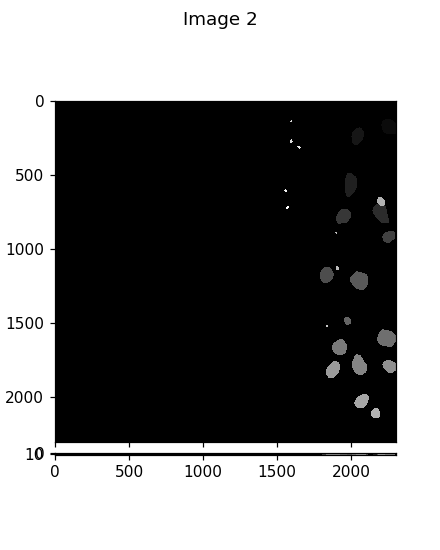

In [21]:
imshow_mark_3d([new_labels, corr_labels3d])

# Copy segmentation labels

In [15]:
# Copy segmentation labels
from shutil import copyfile
data_master_folder = r'/lab/solexa_weissman/puzheng/MERFISH_data'
analysis_master_folder = r'/lab/weissman_imaging/puzheng/MERFISH_analysis'
print(os.listdir(data_master_folder))
experiment_date = os.path.basename(data_folder).split('-')[0]
print(experiment_date)
for _fd in os.listdir(data_master_folder):
    if experiment_date in _fd:
        break
analysis_folder = os.path.join(analysis_master_folder, _fd)
print(analysis_folder)

['20240411-EAECord_MF5', 'SequencingRef', '.DS_Store', '2023_WB_data', '2021_Meng_data']
20240411
/lab/weissman_imaging/puzheng/MERFISH_analysis/20240411-EAECord_MF5


In [16]:
segmentation_target_folder = os.path.join(analysis_folder, 'CellPoseSegment', 'segmentation_label')
print(segmentation_target_folder)
if not os.path.exists(segmentation_target_folder):
    os.makedirs(segmentation_target_folder)
# copy
seg_label_filenames = [os.path.join(watershed_folder, _f) 
                       for _f in os.listdir(watershed_folder) 
                       if 'segmentation_label' in _f and '.npy' in _f]

for _f in seg_label_filenames:
    print(os.path.basename(_f))
    copyfile(_f, os.path.join(segmentation_target_folder, os.path.basename(_f)))

/lab/weissman_imaging/puzheng/MERFISH_analysis/20240411-EAECord_MF5/CellPoseSegment/segmentation_label
segmentation_label_0.npy
segmentation_label_1.npy
segmentation_label_2.npy
segmentation_label_3.npy
segmentation_label_4.npy
segmentation_label_100.npy
segmentation_label_5.npy
segmentation_label_6.npy
segmentation_label_101.npy
segmentation_label_102.npy
segmentation_label_7.npy
segmentation_label_103.npy
segmentation_label_8.npy
segmentation_label_104.npy
segmentation_label_9.npy
segmentation_label_105.npy
segmentation_label_10.npy
segmentation_label_106.npy
segmentation_label_11.npy
segmentation_label_107.npy
segmentation_label_12.npy
segmentation_label_108.npy
segmentation_label_13.npy
segmentation_label_109.npy
segmentation_label_14.npy
segmentation_label_110.npy
segmentation_label_15.npy
segmentation_label_111.npy
segmentation_label_16.npy
segmentation_label_112.npy
segmentation_label_17.npy
segmentation_label_113.npy
segmentation_label_114.npy
segmentation_label_18.npy
segmenta

In [17]:
len(seg_label_filenames)

158

## visualize merlin_output_tif

In [12]:
import tifffile
ims = tifffile.imread(r'Z:\MERFISH_analysis\20230513-wtBrain_MO4\FiducialCorrelationWarp\images\aligned_fiducial_images30.tif')